## Imports

In [3]:
import sys
import pandas as pd
from os.path import abspath, join as opj

sys.path.insert(0, abspath('../helpers/'))
from participant import Participant
from experiment import Experiment

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [5]:
raw_path = '../../data/raw/psiturk-data-raw.tsv'
raw_data = pd.read_csv(raw_path, sep='\t', index_col='Unnamed: 0')
exp = Experiment()
exp.load_questions()
exp.load_lecture_trajs()
exp.load_question_vectors()

## Define experiment class

In [104]:
data_df = pd.read_csv(opj('../../data/raw', 'Graded_results_19f_49.csv'), index_col='Unnamed: 0')

In [108]:
subdata = data_df.loc[data_df.participantID == 1]

In [113]:
subdata.loc[subdata['set'].isin([1, 2])]

,correct?,participantID,qID,set,video
1378,1,1,15,1,1
1379,1,1,29,1,2
1380,0,1,17,1,2
1381,1,1,11,1,1
1382,1,1,18,1,2
1383,1,1,39,1,0
1384,1,1,10,1,1
1385,1,1,3,1,1
1386,1,1,31,1,0
1387,1,1,7,1,1


In [43]:
raw_data = pd.read_csv('../../data/raw/psiturk-data-raw.tsv', sep='\t', index_col='Unnamed: 0')

In [302]:
test = ast.literal_eval(raw_data.loc[0, 'datastring'])

In [152]:
z == decode_unicode_references(test['data'][i]['trialdata'][j]['prompt'])

True

In [252]:
for i in (3, 8, 13):
    for j in range(13):
#         print(test['data'][i]['trialdata'][j]['prompt'])
#         print(decode_unicode_references(test['data'][i]['trialdata'][j]['prompt']))
        print(unescape(test['data'][i]['trialdata'][j]['prompt']))
#         print(questions_df.loc[questions_df.question == test['data'][i]['trialdata'][j]['prompt']])
        x = questions_df.loc[questions_df.question == test['data'][i]['trialdata'][j]['prompt']]
        break
    break

Which of the following would have to be true for the Weak Interaction to cause repulsion or attraction between two objects?


In [315]:
row

uniqueid                          debugdebug0dr3r6:debugdebugtjipdu
assignmentid                                            debugTJIPDU
workerid                                                debug0DR3R6
hitid                                                   debugL0H5X4
ipaddress                                                172.22.0.2
browser                                                      chrome
platform                                                      macos
language                                                    UNKNOWN
cond                                                              0
counterbalance                                                    0
codeversion                                                       1
beginhit                                        2019-10-25 15:22:36
beginexp                                                        NaN
endhit                                                          NaN
bonus                                           

In [255]:
ans_text = ast.literal_eval(test['data'][i+1]['trialdata']['responses'])['Q0']

In [291]:
try:
    a = x.squeeze()[x.squeeze() == ans_text].index[0]
    assert a in 'ABCD'
except (IndexError, AssertionError) as e:
    raise ValueError('test message') from e

In [286]:
try:
    x.squeeze()[x.squeeze() == ans_text+'a'].index[0]
except IndexError as e:
    raise ValueError('test message') from e

ValueError: test message

In [180]:
x = questions_df.loc[questions_df.question == test['data'][i]['trialdata'][j]['prompt'] + 'a']

In [347]:
class Test:
    def __init__(self, num):
        self.num = num
        self.d = {'a': 1, 'b': 2, 'c': 3}
        
    @property
    def prop_test(self):
        return self.num * 100
    
    
    def internal_teset(self, adding_num):
        return self.prop_test + adding_num

In [368]:
np.load('../../data/models/fit_LDA.npy', allow_pickle=True).item()

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [361]:
getattr(testobj, 'internal_tesetad')

AttributeError: 'Test' object has no attribute 'internal_tesetad'

In [323]:
del testobj.d['b']

{'a': 1, 'c': 3, 'd': 4}

In [19]:
questions_df = pd.read_csv('../../data/raw/questions.tsv', sep='\t', 
            names=['index', 'video', 'question', 'A', 'B', 'C', 'D'], index_col='index') 

In [20]:
questions_df

,video,question,A,B,C,D
index,,,,,,
1,1,Why is the gravitational attraction between yo...,Neither you nor your computer has enough mass ...,You and your computer are too close for the gr...,Humans are too small to detect the force of gr...,The gravitational attraction between you and y...
2,1,Which of the following is an example of the We...,A neutron in a radioactive Cesium atom is conv...,Light from the sun collides with a satellite o...,Two protons bound together in a Helium nucleus...,A distant galaxy exerts a small but detectable...
3,1,Roughly how many times stronger is the Weak In...,"10,000,000,000,000,000,000,000,000",10,"1,000,000",The Weak Interaction is less strong than gravity
4,1,Why don't you and your computer experience any...,The weak interaction only acts over extremely ...,The weak interaction between you and your comp...,You and your computer have no net charge,Neither you nor your computer has enough mass ...
5,1,Which of the following is a difference between...,Gravity is only ever attractive while the elec...,Gravity is a much more powerful force than ele...,Gravity can only act over large distances whil...,The electromagnetic force can only act over sm...
6,1,Electricity and magnetism can be shown to be t...,View them in different frames of reference,Switch which charges we call positive and whic...,Consider both the effects over small distances...,Consider both the attractive and repulsive pro...
7,1,Which of the following are the primary two fun...,The Strong Force and the Electromagnetic Force,Gravity and the Weak Interaction,Gravity and the Electromagnetic Force,The Strong Force and the Weak Interaction
8,1,Why does the universe have a very uneven distr...,Positive and negative charges cancel out and b...,Masses tend to repel while charges tend to att...,Masses tend to attract while charges tend to r...,The gravitational interaction acting between m...
9,1,"In your body, there are a tremendous amount of...",The electrons' negative charges are balanced b...,An attractive gravitational force balances out...,The electromagnetic force only acts over very ...,The Electromagnetic force only acts over very ...


In [228]:
questions_df.loc[:, 'question':].applymap(unescape)

,question,A,B,C,D
index,,,,,
1,Why is the gravitational attraction between yo...,Neither you nor your computer has enough mass ...,You and your computer are too close for the gr...,Humans are too small to detect the force of gr...,The gravitational attraction between you and y...
2,Which of the following is an example of the We...,A neutron in a radioactive Cesium atom is conv...,Light from the sun collides with a satellite o...,Two protons bound together in a Helium nucleus...,A distant galaxy exerts a small but detectable...
3,Roughly how many times stronger is the Weak In...,"10,000,000,000,000,000,000,000,000",10,"1,000,000",The Weak Interaction is less strong than gravity
4,Why don't you and your computer experience any...,The weak interaction only acts over extremely ...,The weak interaction between you and your comp...,You and your computer have no net charge,Neither you nor your computer has enough mass ...
5,Which of the following is a difference between...,Gravity is only ever attractive while the elec...,Gravity is a much more powerful force than ele...,Gravity can only act over large distances whil...,The electromagnetic force can only act over sm...
6,Electricity and magnetism can be shown to be t...,View them in different frames of reference,Switch which charges we call positive and whic...,Consider both the effects over small distances...,Consider both the attractive and repulsive pro...
7,Which of the following are the primary two fun...,The Strong Force and the Electromagnetic Force,Gravity and the Weak Interaction,Gravity and the Electromagnetic Force,The Strong Force and the Weak Interaction
8,Why does the universe have a very uneven distr...,Positive and negative charges cancel out and b...,Masses tend to repel while charges tend to att...,Masses tend to attract while charges tend to r...,The gravitational interaction acting between m...
9,"In your body, there are a tremendous amount of...",The electrons' negative charges are balanced b...,An attractive gravitational force balances out...,The electromagnetic force only acts over very ...,The Electromagnetic force only acts over very ...


## Define some functions

In [1]:
def symmetric_KL(a, b, c=.00000000001):
    # symmetrized KL divergence
    return np.divide(entropy(a + c, b + c) + entropy(b + c, a + c), 2)
    
def reconstruct_trace(video_model, questions_model, acc):
    # compute timepoints by questions correlation matrix
    wz = 1 - cdist(video_model, questions_model, metric=symmetric_KL)
    # normalize
    wz -= np.min(wz)
    wz /= np.max(wz)
    # sum over questions
    a = np.sum(wz, axis=1)
    # sum over correctly answered questions
    b = np.sum(wz[:, list(map(bool, acc))], axis=1)
    # divide b by a
    b_a = np.array(np.divide(b, a), ndmin=2)
    # weight the model
    return video_model * b_a.T

In [331]:
test = []
for i in range(5):
    test.append(['a', 'b', 'c', 'd'])

In [333]:
test = pd.DataFrame(test, columns=['qID', 'accuracy', 'block', 'lecture'])

In [344]:
d = {'a':1, 'b':2, 'c':3}

In [371]:
subdata['correct?'].tolist()

[1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [373]:
x = np.load('../../data/trajectories/forces_lecture.npy')

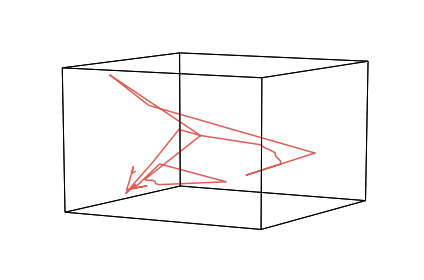

In [375]:
hyp.plot([x])

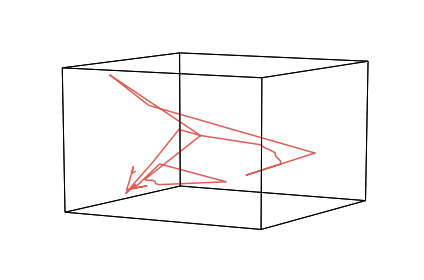

In [376]:
hyp.plot(x)

In [378]:
y = [1, 2, 3]
y += [i for i in []]
y

[1, 2, 3]

In [382]:
isinstance('a', (str, int))

True

In [383]:
'bos' in 'basdoadfjs'

False

In [388]:
x = {'a': 1, 'b': 2, 'c': 3}
y = {'a': 4, 'b': 5, 'c': 6}
z = {'a': 7, 'b': 8, 'c': 9}

In [390]:
participants = [x, y, z]
keys = ['a', 'b']

In [395]:
test = []
test += [val[key] for val in participants for key in keys]

In [397]:
[i for i in []]

[]